### Objective - Apply Random Forest and GBDT on Amazon Fine Food Reviews

### Importing Modules

In [145]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

### Loading the data

In [146]:
con = sqlite3.connect('/Users/mohdsaquib/documents/data/database.sqlite')

In [147]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score!=3""",con)

In [148]:
### Give reviews whose score > 3 as positive and whose score < 3 as negative
def partition(x):
    if x>3:
        return 1
    return 0

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
    

In [149]:
print(filtered_data.shape)

(525814, 10)


In [150]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Exploratory Data Analysis

In [151]:
display = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 and UserId= "AR5J8UI46CURR" ORDER BY ProductID""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [152]:
### Sorting data according to product id in ascending order 
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [153]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [154]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [155]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [156]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [157]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### Preprocessing

In [158]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [159]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'herself', 'isn', "you've", 'won', "should've", 'ours', 'out', 'doesn', 'y', 'off', 'yourselves', 'o', 'them', 'this', 'me', 'did', 'why', 'so', 'should', 'd', 'didn', 'against', 'll', 't', "isn't", "doesn't", 'from', 'under', 'themselves', "mustn't", 'who', 'itself', 'shan', 'hadn', "you'd", 'in', 'that', 'where', 'him', 'more', 'but', 'nor', "hadn't", 'himself', 'what', 'very', 's', 'each', 'theirs', 'all', 'its', 'a', 'wasn', 'is', 'below', 'these', 'my', 'as', 'which', 'few', 'she', 'it', 'when', 'once', 'an', "you'll", 'aren', 'into', 'before', "shan't", 'at', 'just', 'only', 'with', 're', 'they', 'or', 'weren', 'about', 'than', 'mustn', 'again', 'mightn', 'through', 'same', "couldn't", "shouldn't", 'hers', 'then', 'i', 'because', 'we', 'to', 'whom', 'on', "aren't", 'being', "wouldn't", 'his', 'other', 'been', 'having', 'can', 'he', 'was', 'both', 'm', 'between', 'yourself', 'any', 've', 'not', "you're", 'until', 'now', "won't", 'hasn', 'yours', 'am', 'those', 'you', 'here', 'mys

In [160]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [161]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review

In [162]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [163]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [164]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [165]:
print(cleaned_data.shape)
cleaned_data.head()


(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [166]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [167]:
# To randomly sample 100k points from both class
random_sample_data = final.sample(n=100000) 
random_sample_data.shape

(100000, 11)

### Time Based Splitting

In [168]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [169]:
final_sorted_time.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazi look beatlejuic french version vid...


In [178]:
#data splitting for bag of words
y_train=final['Score'][0:49000]
y_cv=final['Score'][49000:70000]
y_test=final['Score'][70000:100000]

In [179]:
train_data=final['CleanedText'][0:49000]
cv_data=final['CleanedText'][49000:70000]
test_data=final['CleanedText'][70000:100000]

### Featurization

### BagofWords

In [188]:
count_vector = CountVectorizer()
bow_train = count_vector.fit_transform(train_data)
bow_cv  = count_vector.transform(cv_data)
bow_test = count_vector.transform(test_data)

In [189]:
bow_train.shape
bow_cv.shape
bow_test.shape

(30000, 27870)

### TFIDF 

In [190]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_train = tfidf_vec.fit_transform(train_data)
tf_cv  = tfidf_vec.transform(cv_data)
tf_test = tfidf_vec.transform(test_data)

### WORD2VEC

In [191]:
# Train your own Word2Vec model using your own text corpus
list_of_sent_train = []
for i in train_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [192]:
list_of_sent_cv = []
for i in cv_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_cv.append(sent)

In [193]:
list_of_sent_test = []
for i in test_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [194]:
len(list_of_sent_train)
print(len(list_of_sent_cv))
len(list_of_sent_test)

21000


30000

In [195]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)

In [196]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9529
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand', 'keep']


### AVG W2V

In [197]:
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

49000


In [198]:
sent_vectors_cv = []
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

21000


In [199]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


### TFIDF-W2V

In [200]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [201]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_cv = []
row = 0
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_cv[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_cv.append(sent_vec)
    row += 1

In [202]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

In [203]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_train.shape
tfw2v_cv= np.array(tfidf_sent_vec_cv)
tfw2v_cv.shape
tfw2v_test= np.array(tfidf_sent_vec_test)
tfw2v_test.shape


(30000, 50)

In [204]:
np.save("tfw2v_train", tfw2v_train)
np.save("tfw2v_cv", tfw2v_cv)
np.save("tfw2v_test", tfw2v_test)

### Applying Random Forest on Bag of Words

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []
estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]
param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC = RandomForestClassifier()
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(bow_train, y_train)
train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']
print("Model with best parameters :\n",model.best_estimator_)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [206]:
opt_depth = model.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",opt_depth)

#Optimal value of n_estimators
opt_estimator = model.best_estimator_.n_estimators
print("The optimal value of no. of base model  is : ",opt_estimator)

The optimal value of max depth of base model is :  60
The optimal value of no. of base model  is :  500


### *Heat map for training data*

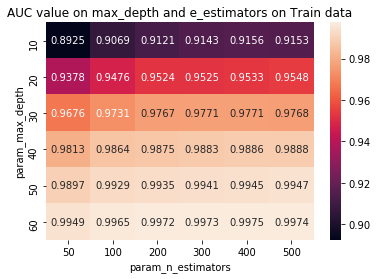

In [207]:
### For training data
df_gridsearch1 = pd.DataFrame(model.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

### *Heat map for CrossValidation data*

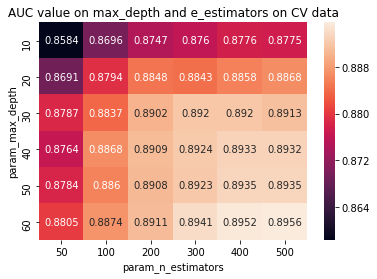

In [208]:
### For Crossvalidation data
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal Depth = 60*
### *Base Estimator=500*

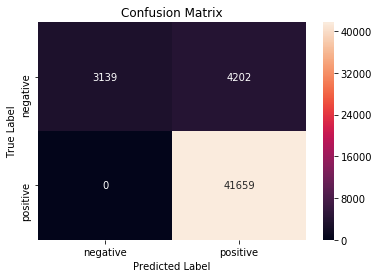

In [209]:
pred_train= model.predict(bow_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### *From the confusion matrix of train data we can say that 3139 points are correctly classified as negative points and 41659 points are correctly classiied as positive points.*

### Testing

In [211]:
clf = RandomForestClassifier(n_estimators=500, max_depth=60, n_jobs=-1)
clf.fit(bow_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### AUC Curve for Train and Test

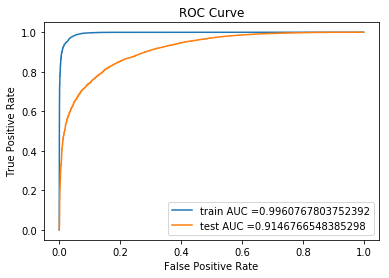

In [212]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(bow_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

### *AUC train = 0.99*
### *AUC test = 0.91*

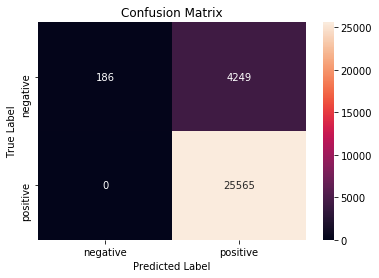

In [213]:
# plot confusion matrix to describe the performance of classifier.
pred = clf.predict(bow_test)
pred_prob = clf.predict_proba(bow_test)[:,1]
cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of test data we can say that 186 points are correctly classified as negative points and 25565 points are correctly classiied as positive points.*

### Classification Report

In [214]:
### Classification Report
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      0.04      0.08      4435
          1       0.86      1.00      0.92     25565

avg / total       0.88      0.86      0.80     30000



### Word Cloud

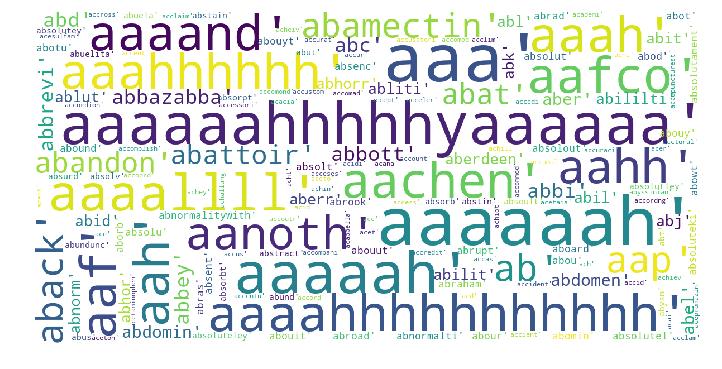

In [216]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

names = count_vector.get_feature_names() 
show_wordcloud(names)

### Random Forest on TFIDF

In [219]:
estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC_tfidf = RandomForestClassifier()
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(tf_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
##Optimal value of max_depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The optimal value of max depth of base model is :  60
The optimal value of n_estimator is :  500


In [220]:
opt_depth = model.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",opt_depth)

#Optimal value of n_estimators
opt_estimator = model.best_estimator_.n_estimators
print("The optimal value of no. of base model  is : ",opt_estimator)

The optimal value of max depth of base model is :  60
The optimal value of no. of base model  is :  500


### Heat map for training data

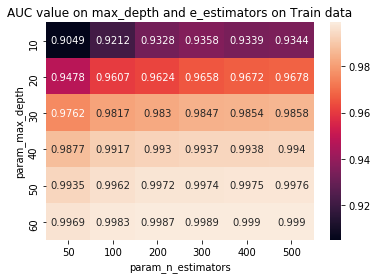

In [221]:
### For training data
df_gridsearch1 = pd.DataFrame(model.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

### Heat map for crossvalidation data

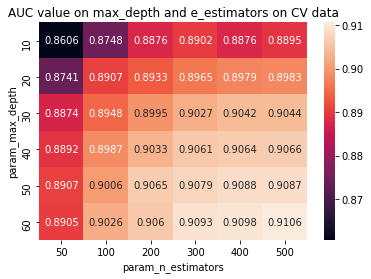

In [222]:
### For Crossvalidation data
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal Depth = 60*
### *Estimators = 500*

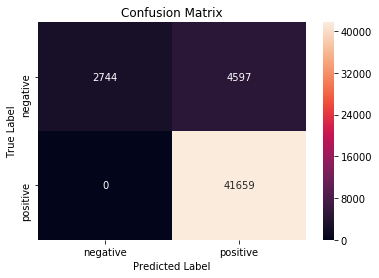

In [224]:
pred_train= model.predict(tf_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of train data we can say that 2744 points are correctly classified as negative points and 41659 points are correctly classiied as positive points.*

### Testing

In [226]:
clf = RandomForestClassifier(n_estimators=500, max_depth=60, n_jobs=-1)
clf.fit(tf_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### AUC curve for test and train

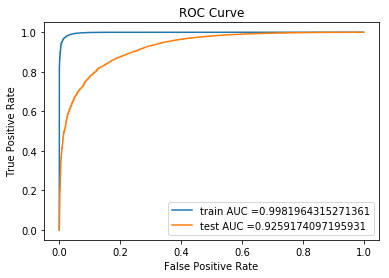

In [227]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(tf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(tf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

### AUC train = 0.99
### AUC test = 0.92

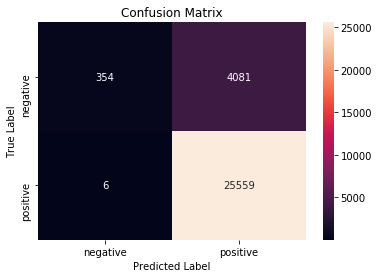

In [228]:
# plot confusion matrix to describe the performance of classifier.
pred = clf.predict(tf_test)
pred_prob = clf.predict_proba(tf_test)[:,1]
cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of test data we can say that 354 points are correctly classified as negative points and 25559 points are correctly classiied as positive points.*

### Classification Report

In [229]:
### Classification Report
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.98      0.08      0.15      4435
          1       0.86      1.00      0.93     25565

avg / total       0.88      0.86      0.81     30000



### World Cloud

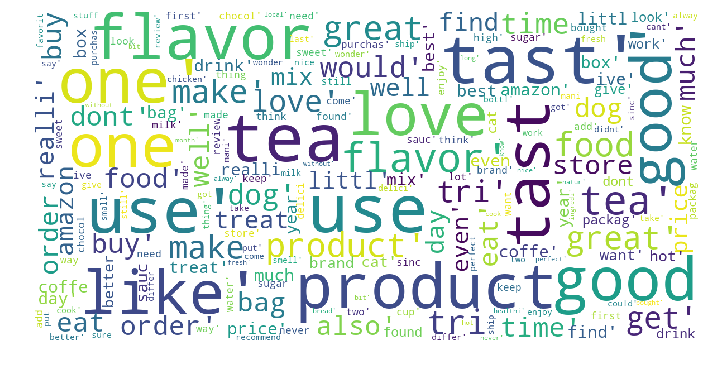

In [232]:
names_tf = tfidf_vec.get_feature_names() 
show_wordcloud(names_tf)

### Random Forest on Average W2V

In [240]:
estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC = RandomForestClassifier()
model_w2v = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_w2v.fit(sent_vectors_train, y_train)


print("Model with best parameters :\n",model_w2v.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_w2v.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_w2v.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The optimal value of max depth of base model is :  10
The optimal value of n_estimator is :  500


In [241]:
opt_depth = model_w2v.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",opt_depth)

#Optimal value of n_estimators
opt_estimator = model_w2v.best_estimator_.n_estimators
print("The optimal value of no. of base model  is : ",opt_estimator)

The optimal value of max depth of base model is :  10
The optimal value of no. of base model  is :  500


### Heat map for train data

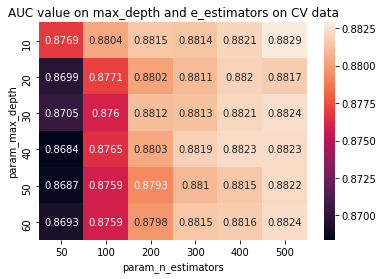

In [244]:
df_gridsearch = pd.DataFrame(model_w2v.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### Heat map for CrossValidation data

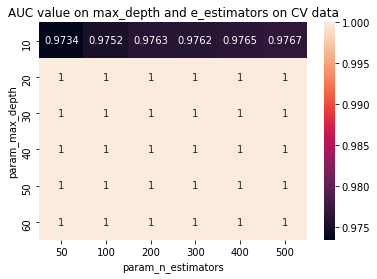

In [246]:
df_gridsearch = pd.DataFrame(model_w2v.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal Depth = 10*
### *Estimators = 500*

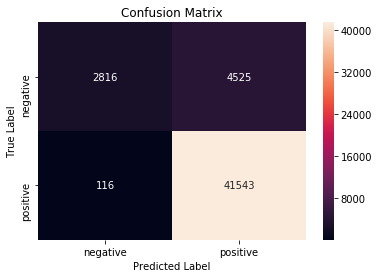

In [248]:

pred_train= model_w2v.predict(sent_vectors_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of train data we can say that 2816 points are correctly classified as negative points and 41543 points are correctly classiied as positive points.*

### Testing

In [302]:
clf_w2v = RandomForestClassifier(n_estimators=500, max_depth=10, n_jobs=-1)
clf_w2v.fit(sent_vectors_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### AUC Curve for train and test

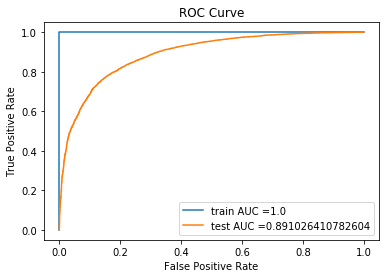

In [250]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_w2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_w2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

### *AUC Train = 1*
### *AUC Test = 0.89*
#### * This model is overfitting a lot.*

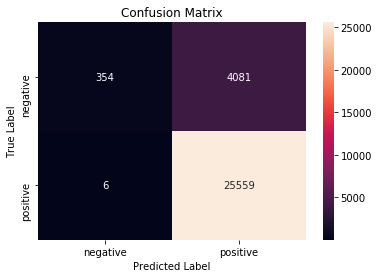

In [251]:
cm = confusion_matrix(y_test, pred)
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of test data we can say that 354 points are correctly classified as negative points and 25559 points are correctly classiied as positive points.*

### Classification Report

In [252]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))


             precision    recall  f1-score   support

          0       0.98      0.08      0.15      4435
          1       0.86      1.00      0.93     25565

avg / total       0.88      0.86      0.81     30000



### Random Forest on Tfidf-W2v

In [254]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_train.shape
tfw2v_cv= np.array(tfidf_sent_vec_cv)
tfw2v_cv.shape
tfw2v_test= np.array(tfidf_sent_vec_test)
tfw2v_test.shape

(30000, 50)

In [255]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC = RandomForestClassifier()
model_tf_w2v = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_tf_w2v.fit(tfw2v_train, y_train)

print("Model with best parameters :\n",model_tf_w2v.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_tf_w2v.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_tf_w2v.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The optimal value of max depth of base model is :  20
The optimal value of n_estimator is :  500


### Heat map for train and cross validation data

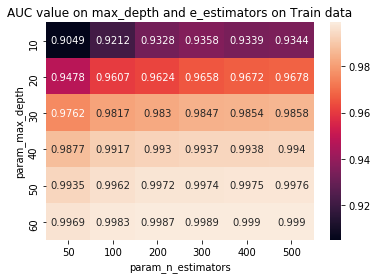

In [258]:
df_gridsearch1 = pd.DataFrame(model.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

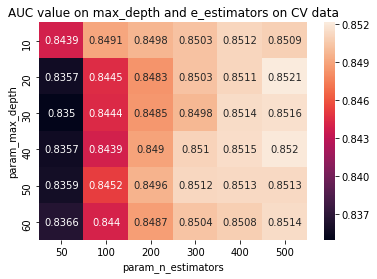

In [257]:
df_gridsearch = pd.DataFrame(model_tf_w2v.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal Depth = 20*
### *Estimators = 500*

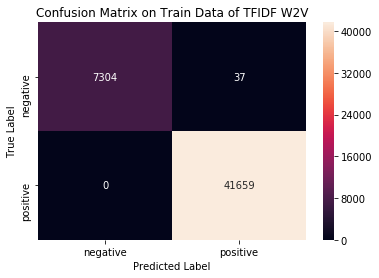

In [259]:
pred_train= model_tf_w2v.predict(tfw2v_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix on Train Data of TFIDF W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of train data we can say that 7304 points are correctly classified as negative points and 41659 points are correctly classiied as positive points.*

### Testing

In [301]:
clf_tf_w2v = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1)
clf_tf_w2v.fit(tfw2v_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### AUC cure for train and test

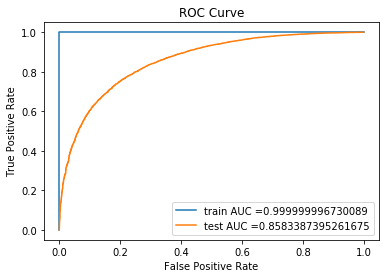

In [303]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_tf_w2v.predict_proba(tfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_tf_w2v.predict_proba(tfw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

### *Train AUC = 1*
### *Test AUC = 0.85*

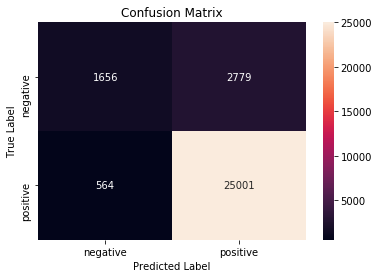

In [304]:
cm = confusion_matrix(y_test, pred)
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of test data we can say that 1656 points are correctly classified as negative points and 25001 points are correctly classiied as positive points.*

### Classification Report

In [263]:
# To show main classification report
print(classification_report(y_test, pred))


             precision    recall  f1-score   support

          0       0.98      0.08      0.15      4435
          1       0.86      1.00      0.93     25565

avg / total       0.88      0.86      0.81     30000



### XGBOOST on BOW

In [265]:
%timeit
from xgboost import XGBClassifier

estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb1 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb1.fit(bow_train, y_train)


print("Model with best parameters :\n",model_xgb1.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb1.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb1.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb1.best_score_)
print("AUC value on CV data:",model_xgb1.score(bow_cv, y_cv) )

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  9
The optimal value of n_estimator is :  500
AUC value on Train data: 0.92542377960805
AUC value on CV data: 0.940137999459638


### Heat map for train and cross validation data

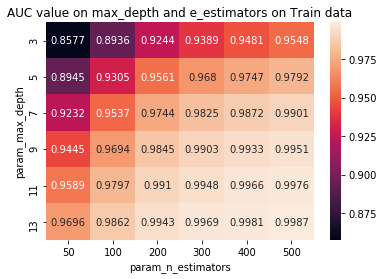

In [271]:
df_gridsearch1 = pd.DataFrame(model_xgb1.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()


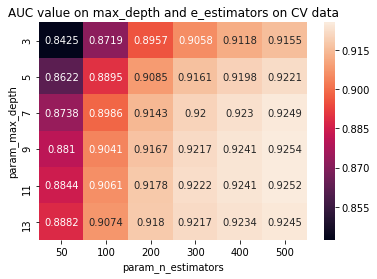

In [272]:
df_gridsearch = pd.DataFrame(model_xgb1.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal depth = 9*
### *Optimal estimators = 500*

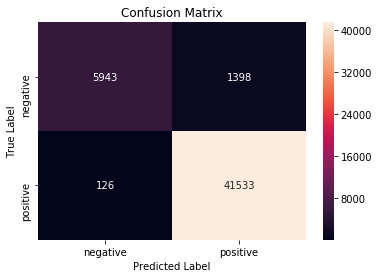

In [273]:
pred_train= model_xgb1.predict(bow_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of train data we can say that 5943 points are correctly classified as negative points and 41533 points are correctly classiied as positive points.*

### Testing

In [274]:
clf = XGBClassifier(booster='gbtree',max_depth=9,n_estimators=500)
clf.fit(bow_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### AUC curve for test and train

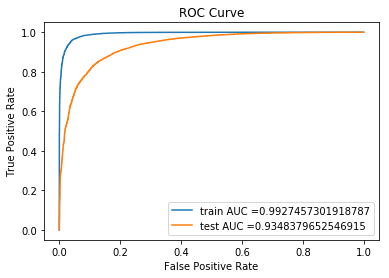

In [275]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(bow_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

### *Train AUC  = 0.99*
### *Test AUC = 0.93*

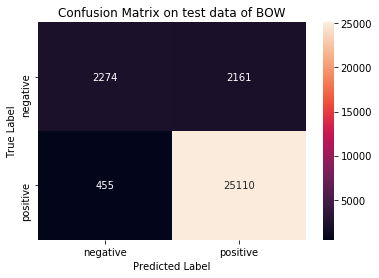

In [276]:
pred = clf.predict(bow_test)
pred_prob = clf.predict_proba(bow_test)[:,1]
cm = confusion_matrix(y_test, pred)
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix on test data of BOW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of test data we can say that 2274 points are correctly classified as negative points and 25110 points are correctly classiied as positive points.*

### Classification Report

In [277]:
# To show main classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.83      0.51      0.63      4435
          1       0.92      0.98      0.95     25565

avg / total       0.91      0.91      0.90     30000



### XGBOOST ON TFIDF

In [266]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb2 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb2.fit(tf_train, y_train)


print("Model with best parameters :\n",model_xgb2.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb2.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb2.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb2.best_score_)
print("AUC value on CV data:",model_xgb2.score(tf_cv, y_cv) )

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  11
The optimal value of n_estimator is :  500
AUC value on Train data: 0.927307464236947
AUC value on CV data: 0.9445064248724149


### Heat map for train and crossvalidation data

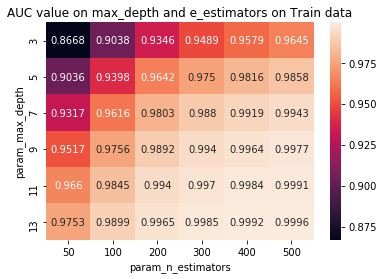

In [278]:
df_gridsearch1 = pd.DataFrame(model_xgb2.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()


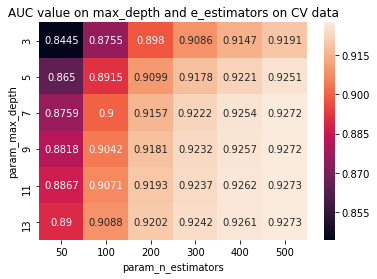

In [279]:
df_gridsearch = pd.DataFrame(model_xgb2.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal depth = 11*
### *Estimators = 500*

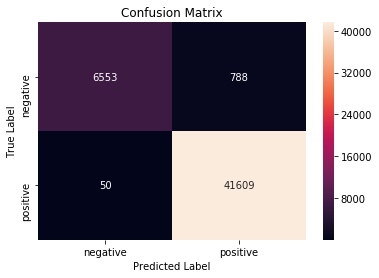

In [280]:
pred_train= model_xgb2.predict(tf_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of train data we can say that 6553 points are correctly classified as negative points and 41609 points are correctly classiied as positive points.*

### Testing

In [281]:
clf_2 = XGBClassifier(booster='gbtree',max_depth=11,n_estimators=500)
clf_2.fit(tf_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### AUC curve for test and train data 

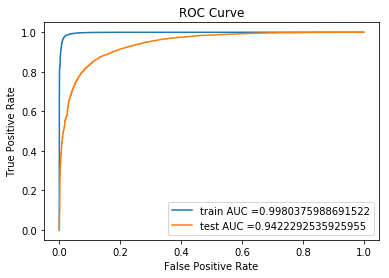

In [282]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_2.predict_proba(tf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_2.predict_proba(tf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()


### *train AUC = 0.99*
### *test AUC = 0.94*

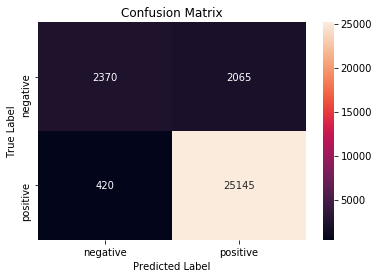

In [283]:
pred = clf_2.predict(tf_test)
pred_prob = clf_2.predict_proba(tf_test)[:,1]
cm = confusion_matrix(y_test, pred)
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of test data we can say that 2370 points are correctly classified as negative points and 25145 points are correctly classiied as positive points.*

### Classification Report

In [284]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.85      0.53      0.66      4435
          1       0.92      0.98      0.95     25565

avg / total       0.91      0.92      0.91     30000



### XGBOOST ON AVG-W2V

In [267]:
avgw2v_train= np.array(sent_vectors_train)
print(avgw2v_train.shape)
avgw2v_cv= np.array(sent_vectors_cv)
print(avgw2v_cv.shape)
avgw2v_test= np.array(sent_vectors_test)
print(avgw2v_test.shape)

(49000, 50)
(21000, 50)
(30000, 50)


In [268]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb3 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb3.fit(avgw2v_train, y_train)


print("Model with best parameters :\n",model_xgb3.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb3.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb3.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb3.best_score_)
print("AUC value on CV data:",model_xgb3.score(avgw2v_cv, y_cv))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  13
The optimal value of n_estimator is :  500
AUC value on Train data: 0.8988384594317134
AUC value on CV data: 0.9093925089079862


### Heat map on Train and crossvalidate data

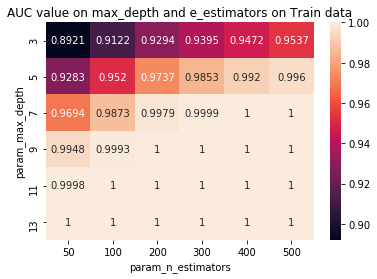

In [286]:
df_gridsearch1 = pd.DataFrame(model_xgb3.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

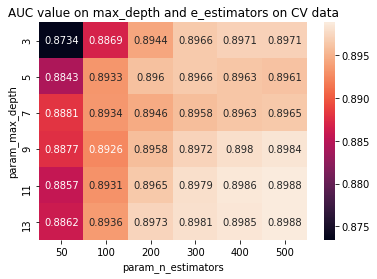

In [287]:
df_gridsearch = pd.DataFrame(model_xgb3.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal Depth =13*
### *Estimators = 500*

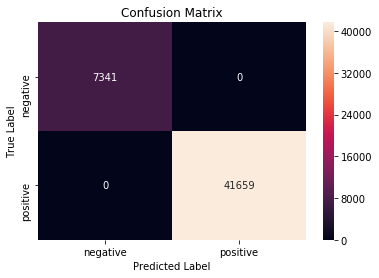

In [288]:
pred_train= model_xgb3.predict(avgw2v_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of train data we can say that 7341 points are correctly classified as negative points and 41659 points are correctly classiied as positive points.*

### Testing

In [289]:
clf_3 = XGBClassifier(booster='gbtree',max_depth=13,n_estimators=500)
clf_3.fit(avgw2v_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### AUC curve for test and train

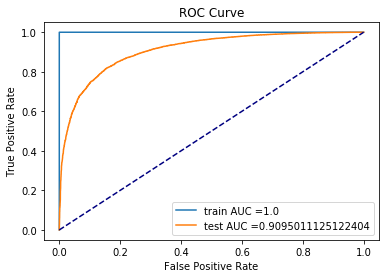

In [290]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_3.predict_proba(avgw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_3.predict_proba(avgw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

### *AUC train = 1*
### *AUC test = 0.90*

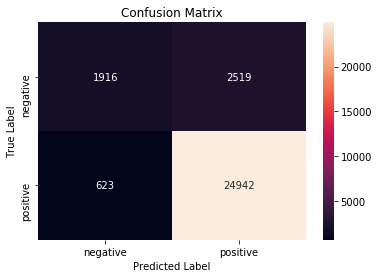

In [291]:
pred = clf_3.predict(avgw2v_test)
pred_prob = clf_3.predict_proba(avgw2v_test)[:,1]
cm = confusion_matrix(y_test, pred)
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of train data we can say that 1916 points are correctly classified as negative points and 24942 points are correctly classiied as positive points.*

### Classification Report

In [292]:
# To show main classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.75      0.43      0.55      4435
          1       0.91      0.98      0.94     25565

avg / total       0.89      0.90      0.88     30000



### XGBoost on tfidf-w2v

In [269]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb4 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb4.fit(tfw2v_train, y_train)


print("Model with best parameters :\n",model_xgb4.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb4.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb4.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb4.best_score_)
print("AUC value on CV data:",model_xgb4.score(tfw2v_cv, y_cv))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  11
The optimal value of n_estimator is :  500
AUC value on Train data: 0.8736109878271338
AUC value on CV data: 0.8870146886078117


### Heat map for train and cross validate data 

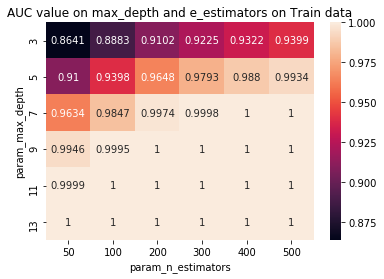

In [293]:
df_gridsearch1 = pd.DataFrame(model_xgb4.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()


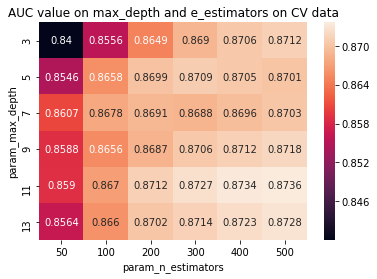

In [294]:
df_gridsearch = pd.DataFrame(model_xgb4.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

### *Optimal Depth* = 11
### *Estimators = 500*

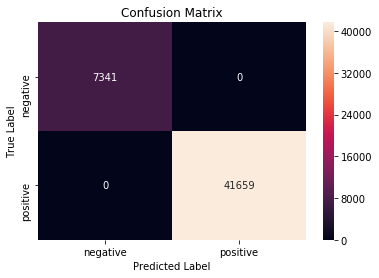

In [295]:
pred_train= model_xgb4.predict(tfw2v_train)
cm = confusion_matrix(y_train, pred_train)
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### *From the confusion matrix of train data we can say that 731 points are correctly classified as negative points and 41659 points are correctly classiied as positive points.*

### Testing

In [296]:
clf_4 = XGBClassifier(booster='gbtree',max_depth=11,n_estimators=500)
clf_4.fit(tfw2v_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### AUC curve for train and test data

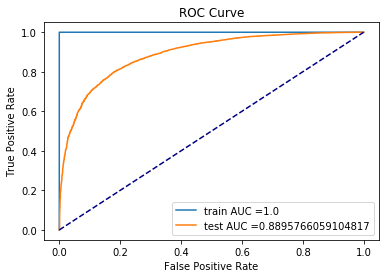

In [297]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_4.predict_proba(tfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_4.predict_proba(tfw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()


### Train AUC = 1
### Test AUC = 0.88

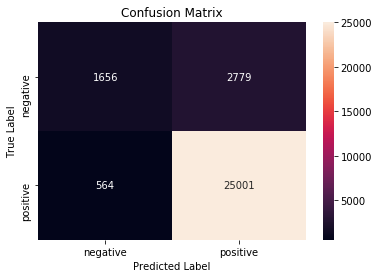

In [298]:
pred = clf_4.predict(tfw2v_test)
pred_prob = clf_4.predict_proba(tfw2v_test)[:,1]
cm = confusion_matrix(y_test, pred)

# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### *From the confusion matrix of test data we can say that 1656 points are correctly classified as negative points and 25001 points are correctly classiied as positive points.*

### Classification Report

In [299]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.75      0.37      0.50      4435
          1       0.90      0.98      0.94     25565

avg / total       0.88      0.89      0.87     30000



### Conclusion

In [305]:
from prettytable import PrettyTable
ptable = PrettyTable()

vec1 = "BOW"
vec2 = "TFIDF"
vec3 = "AVG-W2V"
vec4 = "TFIDF-W2V"

model1 = 'Random Forest'
model2 = 'GBDT using XGBOOST'


ptable.field_names = ["Vectorizer","Model","Opt_Depth","Opt_learners","Train AUC","Test AUC"]

ptable.add_row([vec1,model1,60,500,0.99,0.91])
ptable.add_row([vec1,model2,9,500,0.99,0.93])
ptable.add_row([vec2,model1,60,500,0.99,0.92])
ptable.add_row([vec2,model2,11,500,0.99,0.94])
ptable.add_row([vec3,model1,10,500,1,0.89])
ptable.add_row([vec3,model2,13,500,1,0.88])
ptable.add_row([vec4,model1,20,500,1,0.89])
ptable.add_row([vec4,model2,11,500,1,0.88])

print(ptable)

+------------+--------------------+-----------+--------------+-----------+----------+
| Vectorizer |       Model        | Opt_Depth | Opt_learners | Train AUC | Test AUC |
+------------+--------------------+-----------+--------------+-----------+----------+
|    BOW     |   Random Forest    |     60    |     500      |    0.99   |   0.91   |
|    BOW     | GBDT using XGBOOST |     9     |     500      |    0.99   |   0.93   |
|   TFIDF    |   Random Forest    |     60    |     500      |    0.99   |   0.92   |
|   TFIDF    | GBDT using XGBOOST |     11    |     500      |    0.99   |   0.94   |
|  AVG-W2V   |   Random Forest    |     10    |     500      |     1     |   0.89   |
|  AVG-W2V   | GBDT using XGBOOST |     13    |     500      |     1     |   0.88   |
| TFIDF-W2V  |   Random Forest    |     20    |     500      |     1     |   0.89   |
| TFIDF-W2V  | GBDT using XGBOOST |     11    |     500      |     1     |   0.88   |
+------------+--------------------+-----------+-------

#### *The best model is GBDT using XGBOOST on TFIDF with an AUC of 0.94.*